This code reads from a .ubx file logged using ubxstreamtifiles.py or copied from the phone and parses it into records, then identifies the UBX-NAV-SVINFO records and turns its data into a pandas table.  

We can plot this data according to satellite quality to see how changes in the shielding or the tilt of the device affects what it can see in the sky.

It is currently incomplete because we have no need for all the information.  
The count of satellites with quality="code and carrier locked and time synchronized"
has been programmed into the Hanglog3 display so we can see the quality in the field.


In [15]:
import struct

def parsegenubxrecords(x):
    k = x.find(b"\xb5\x62")
    while k != -1:
        x = x[k:]
        if len(x) < 6:
            break
        payloadlength = x[4] + x[5]*256
        if len(x) < 8 + payloadlength:
            break
        comm = x[2:6+payloadlength]
        ca, cb = 0, 0
        for c in comm:
            ca = (ca + c) & 0xFF
            cb = (cb + ca) & 0xFF
        if (x[6+payloadlength], x[7+payloadlength]) == (ca, cb):
            yield x[2], x[3], x[6:6+payloadlength]
            x = x[8+payloadlength:]
        else:
            print("Bad checksum x-", len(x), payloadlength)
            #print(x[:10+payloadlength])
            x = x[2:]
        k = x.find(b"\xb5\x62")
        if k > 0:
            print("skipping", k, "bytes between records")

def parseUBX_NAV_SVINFO(payload):  # 0x01, 0x30
    iTOW, numCH, globalFlags, reserved1 = struct.unpack("<IBBH", payload[:8])
    iTOW, numCH, globalFlags, reserved1
    assert len(payload) == 8 + 12*numCH
    srecs = [ ]
    blockvars = ("chn", "svid", "flags", "quality", "cno", "elev", "azim", "prRes")
    for i in range(numCH):
        srec = dict(zip(blockvars, struct.unpack("<BBBBBbhi", payload[8+i*12:20+i*12])))
        srec["iTOW"] = iTOW
        srecs.append(srec)
    return srecs

def parseUBX_NAV_CLOCK(payload):  # 0x01, 0x22
    iTOW, numCH, globalFlags, reserved1 = struct.unpack("<IBBH", payload[:8])
    iTOW, numCH, globalFlags, reserved1
    assert len(payload) == 8 + 12*numCH
    srecs = [ ]
    blockvars = ("iTOW", "clkB", "clkD", "tAcc", "fAcc")
    return dict(zip(blockvars, struct.unpack("<IiiII", payload)))


#if (r[0], r[1]) == (0x01, 0x30):
#    parseUBX_NAV_SVINFO(r[2])
#if (r[0], r[1]) == (0x01, 0x22):
#    parseUBX_NAV_CLOCK(r[2])
#if (r[0], r[1]) == (0x02, 0x15):
#    parseUBX_RXM_RAWX(r[2])
#if (r[0], r[1]) == (0x02, 0x13):
#    parseUBX_RXM_SFRBX(r[2])


In [16]:
fdata = "../sparedata/dataB.ubx"
fdata = "../hanglog/dd_20200714204857/sdhdata-2020-07-14_20-48-44C.ubx"
fdata = "/home/julian/repositories/RTK_on_the_beach/hanglog/dd_20200715192549/hdata-2020-07-15_08-53-15C.ubx"
fdata = "../hanglog/dd_2020_07_18_181202/hdata-2020-07-18_18-09-54C.ubx"

x = open(fdata, "rb").read()
recs = list(parsegenubxrecords(x))


Bad checksum x- 1055749 432
skipping 441 bytes between records
Bad checksum x- 955676 464
skipping 260 bytes between records
Bad checksum x- 955358 48
skipping 52 bytes between records
skipping 224 bytes between records
Bad checksum x- 39374 260
skipping 137 bytes between records
Bad checksum x- 6911 260
skipping 197 bytes between records


In [17]:
set([(r[0], r[1]) for r in recs])

{(1, 34), (1, 48), (2, 19), (2, 21), (33, 4)}

In [9]:
x.find(b"\xb5\x62\x01\x30")
0x21

33

In [4]:
for k in recs:
    if k[0] == 0x21 and k[1] == 0x04:
        y.append(k[2])
        print(k[2])

In [18]:
q = x.find(b"\xb5\x62\x21\x04")
q1 = x.find(b"\xb5\x62\x21\x04", 700)
print(q1)
list(parsegenubxrecords(x[q+1000:q1+40]))[-5:]
y = []
for k in parsegenubxrecords(x):
    if k[0] == 0x21 and k[1] == 0x04:
        y.append(k[2])



44475
Bad checksum x- 1055749 432
skipping 441 bytes between records
Bad checksum x- 955676 464
skipping 260 bytes between records
Bad checksum x- 955358 48
skipping 52 bytes between records
skipping 224 bytes between records
Bad checksum x- 39374 260
skipping 137 bytes between records
Bad checksum x- 6911 260
skipping 197 bytes between records


In [19]:
for k in y:
    print(k)


b'battvolt=7.44v'
b'battvolt=7.31v'
b'battvolt=7.24v'
b'battvolt=7.22v'
b'battvolt=7.12v'
b'battvolt=7.03v'
b'battvolt=7.01v'
b'battvolt=6.98v'


In [20]:
import struct
import pandas

srecs = [ ]
for r in recs:
    if (r[0], r[1]) == (0x01, 0x30):
        srecs.extend(parseUBX_NAV_SVINFO(r[2]))
df = pandas.DataFrame(srecs)

df["iTOW"] = df.iTOW*pandas.Timedelta(1, "ms")
df["td"] = df["iTOW"]
df = df.set_index("td")
df.index.name = ""

flagbits = ("svUsed", "diffCorr", "orbitAvail", "orbitEph", "unhealthy", "orbitAlm", "orbitAop", "smoothed")
for i, f in enumerate(flagbits):
    df[f] = (df.flags & (1<<i)).astype(bool)
del df["flags"]

#quality: 0: no signal
#         1: searching signal
#         2: signal acquired
#         3: signal detected but unusable
#         4: code locked and time synchronized
#         5, 6, 7: code and carrier locked and time synchronized


In [21]:
pandas.to_datetime("2020-02-02")

Timestamp('2020-02-02 00:00:00')

KeyboardInterrupt: 

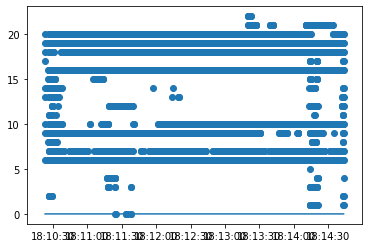

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

ts, y = [ ], [ ]
for index, row in df.iterrows():
    if row.quality <= 4 and row.chn != 255:
        ts.append(pandas.to_datetime("2020-02-02") + row.iTOW)
        y.append(row.chn)
plt.plot(ts, [0]*len(y))
plt.scatter(ts, y)

ts, y = [ ], [ ]
for index, row in df.iterrows():
    if row.quality > 4 and row.chn != 255:
        ts.append(pandas.to_datetime("2020-02-02") + row.iTOW)
        y.append(row.chn)
plt.scatter(ts, y)


In [ ]:
set(df.svid)

In [ ]:
df["td"] = df.iTOW*pandas.Timedelta(1, "ms")
k = df.set_index("td")
k.index.name = ""
del k["iTOW"]
k

In [35]:
import pandas
pandas.DataFrame
 df = pd.DataFrame(index=np.arange(0, numberOfRows), columns=('lib', 'qty1', 'qty2') )
s

pandas.core.frame.DataFrame

In [ ]:
#vUsed
diffCorr
orbitAvail
orbitEph
unhealthy
orbitAlm
orbitAop
smoothed
